In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import re
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mticker

# Directories
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / 'data'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

plt.rcParams['font.family'] = 'calibri'

# Matplotlib style for academic look
plt.rcParams.update({
    'font.family': 'calibri',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'figure.dpi': 100
})

scen_colors = {
    'BAU':          '#501d8a',
    'Moderate':     '#e55709',
    'Aggressive':   '#1c8041',
}

rcp_linestyles = {
    'RCP60':       ':',   # dotted
    'RCP45':  '--',  # dashed
    'RCP26':'-',   # solid
}

rcp_alpha = {
    'RCP60': 1.0,
    'RCP45': 1.0,
    'RCP45': 1.0,
}


In [2]:
A = 0.2
A_int = int(round(A * 10))        # 0.2 -> 2
A_str = f"{A_int:02d}"            # -> "02"

In [3]:
# ___ 1. Data Import & Initialise ___

csv_path = RESULTS_DIR / f"AEF_CEF_all_A_{A_str}.csv"
aef_cef_all = pd.read_csv(csv_path)

methods = aef_cef_all['method'].unique()
print("Impact categories (methods):")
for m in methods:
    print(f"- {m}")


baseline = (
    aef_cef_all
      .query("RCP == 'RCP60' and scenario == 'BAU'")
      .set_index(['method','year'])[['AEF','CEF']]
      .rename(columns={'AEF':'AEF_baseline','CEF':'CEF_baseline'})
)
df = (
    aef_cef_all
      .set_index(['method','year'])
      .join(baseline)
      .reset_index()
)

# ── 2. Compute %-differences ──
# df['AEF_norm'] = df['AEF'] / df['AEF_baseline']
# df['CEF_norm'] = df['CEF'] / df['CEF_baseline']
# df['AEF_pct']  = (df['AEF_norm'] - 1) * 100
# df['CEF_pct']  = (df['CEF_norm'] - 1) * 100
# "Improvement %" = (baseline − current) / |baseline|  × 100
df['AEF_pct'] = (df['AEF_baseline'] - df['AEF']) / df['AEF_baseline'].abs() * 100
df['CEF_pct'] = (df['CEF_baseline'] - df['CEF']) / df['CEF_baseline'].abs() * 100

Impact categories (methods):
- EF v3.1, acidification, accumulated exceedance (AE)
- EF v3.1, climate change, global warming potential (GWP100)
- EF v3.1, climate change: biogenic, global warming potential (GWP100)
- EF v3.1, climate change: fossil, global warming potential (GWP100)
- EF v3.1, climate change: land use and land use change, global warming potential (GWP100)
- EF v3.1, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe)
- EF v3.1, ecotoxicity: freshwater, inorganics, comparative toxic unit for ecosystems (CTUe)
- EF v3.1, ecotoxicity: freshwater, organics, comparative toxic unit for ecosystems (CTUe)
- EF v3.1, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels
- EF v3.1, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P)
- EF v3.1, eutrophication: marine, fraction of nutrients reaching marine end compartment (N)
- EF v3.1, eutrophication: terrestrial, accumulated exceedance (AE)
- EF v

In [4]:
# ___ 2. %-Difference Line Plots with facets, milestones & dual‐axis ___

diff_dir = RESULTS_DIR / f"AEF_CEF_difference_A_{A_str}"
diff_dir.mkdir(exist_ok=True)      # will hold our CSV export + plots

# Export the difference table for later inspection
diff_csv = diff_dir / f"AEF_CEF_pct_diff_A_{A_str}.csv"
df.to_csv(diff_csv, index=False)
print(f"▶ Exported percent-difference table to {diff_csv}")

▶ Exported percent-difference table to E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\AEF_CEF_difference_A_02\AEF_CEF_pct_diff_A_02.csv


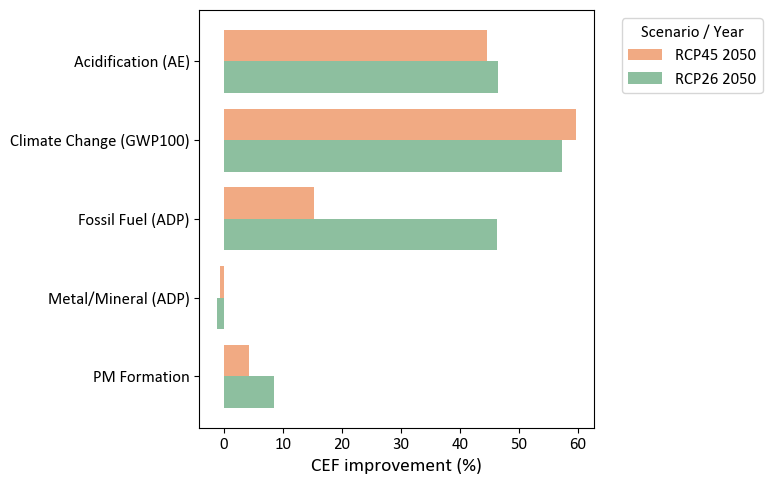

In [5]:
import matplotlib.pyplot as plt

# 1. define your five methods of interest (full names)
selected_methods = [
    "EF v3.1, acidification, accumulated exceedance (AE)",
    "EF v3.1, climate change, global warming potential (GWP100)",
    "EF v3.1, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels",
    "EF v3.1, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves)",
    "EF v3.1, particulate matter formation, impact on human health"
]

# 1a. mapping to new shorter labels
rename_dict = {
    "EF v3.1, acidification, accumulated exceedance (AE)": "Acidification (AE)",
    "EF v3.1, climate change, global warming potential (GWP100)": "Climate Change (GWP100)",
    "EF v3.1, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels": "Fossil Fuel (ADP)",
    "EF v3.1, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves)": "Metal/Mineral (ADP)",
    "EF v3.1, particulate matter formation, impact on human health": "PM Formation",
}

# 2. filter & pivot exactly as before
df_sub = (
    df
    .loc[
        lambda d: d['method'].isin(selected_methods) &
                  (d['scenario'] == 'BAU') &
                  d['RCP'].isin(['RCP45', 'RCP26']) &
                  d['year'].isin([2050])
    ]
    .pivot(index='method', columns=['RCP', 'year'], values='CEF_pct')
    .rename_axis([None, None], axis=1)
    .sort_index(axis=0, key=lambda methods: [selected_methods.index(m) for m in methods])
)

# 3. rename the row‐index to your short labels
df_sub.rename(index=rename_dict, inplace=True)

# flatten the column MultiIndex into strings for nicer legend labels
df_sub.columns = [f"{rcp} {year}" for rcp, year in df_sub.columns]
df_sub = df_sub[['RCP45 2050', 'RCP26 2050']]

# 4. plot with your four colors
colors = ['#e55709', '#1c8041']

fig, ax = plt.subplots(figsize=(8, 5))


df_sub.plot(kind='barh', ax=ax, width=0.8, color=colors, alpha=0.5, legend=False)

ax.set_xlabel("CEF improvement (%)")
ax.set_ylabel("")
ax.invert_yaxis()

# grab what matplotlib thinks the legend should be
handles, labels = ax.get_legend_handles_labels()

# force them into the exact order of your columns
desired = df_sub.columns.tolist()
handles = [handles[labels.index(lbl)] for lbl in desired]
labels  = desired

ax.legend(handles, labels,
          title="Scenario / Year",
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

plt.tight_layout()
plt.show()

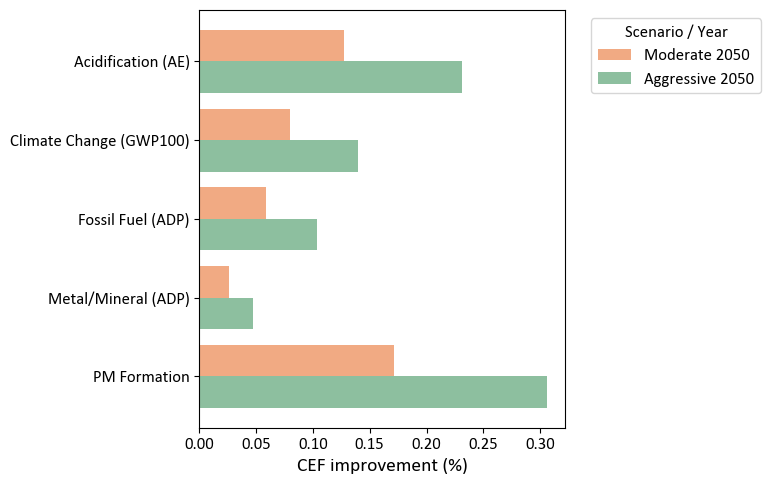

In [31]:
# … keep imports, selected_methods, rename_dict, etc. …

# 2. filter & pivot for RCP60 + Moderate/Aggressive
df_sub = (
    df
    .loc[
        lambda d: d['method'].isin(selected_methods) &
                  (d['RCP'] == 'RCP60') &
                  d['scenario'].isin(['Moderate', 'Aggressive']) &
                  d['year'].isin([2050])
    ]
    # pivot on scenario & year instead of RCP & year
    .pivot(index='method', columns=['scenario', 'year'], values='CEF_pct')
    .rename_axis([None, None], axis=1)
    .sort_index(
        axis=0,
        key=lambda methods: [selected_methods.index(m) for m in methods]
    )
)

# 3. rename the row‐index to your short labels
df_sub.rename(index=rename_dict, inplace=True)

# flatten the new MultiIndex into "Scenario Year"
df_sub.columns = [f"{scen} {yr}" for scen, yr in df_sub.columns]

# 4. plot with your four colors
colors = ['#e55709', '#1c8041']

fig, ax = plt.subplots(figsize=(8, 5))

df_sub.plot(
    kind='barh',
    ax=ax,
    width=0.8,
    color=colors,
    alpha=0.5,
    legend=False
)

ax.set_xlabel("CEF improvement (%)")
ax.set_ylabel("")
ax.invert_yaxis()

# rebuild legend in the exact left‐to‐right order
handles, labels = ax.get_legend_handles_labels()
desired = df_sub.columns.tolist()
handles = [handles[labels.index(lbl)] for lbl in desired]
labels = desired

ax.legend(
    handles, labels,
    title="Scenario / Year",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()


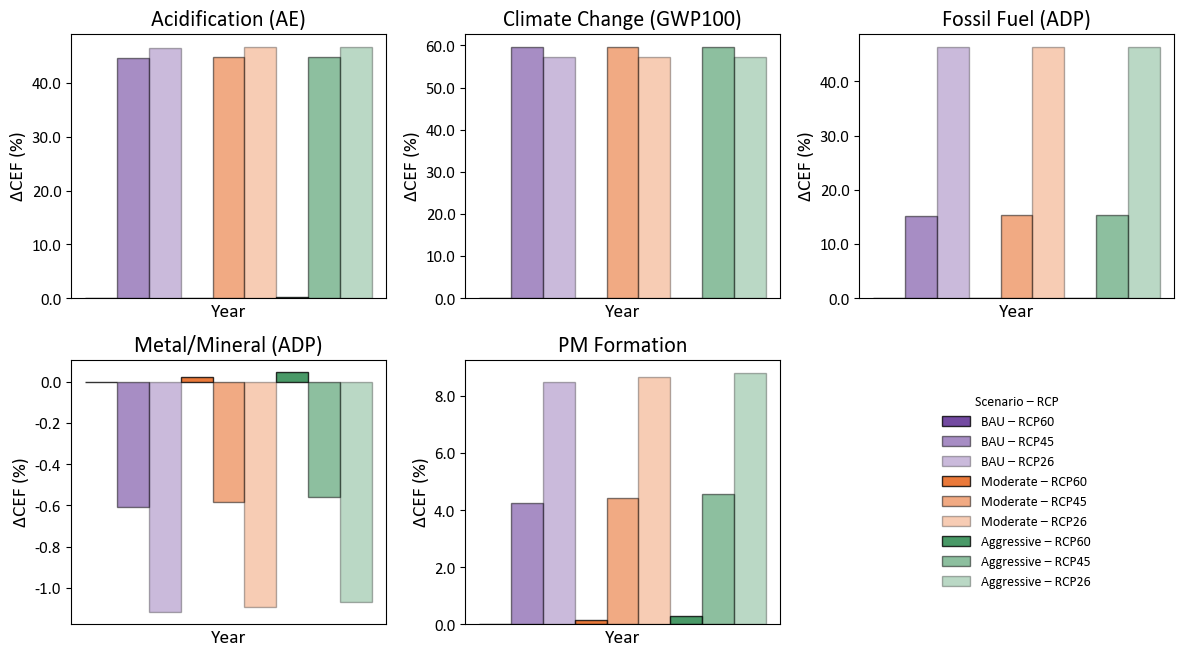

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 1. prepare data ---
years = [2050]
df_sel = (
    df.loc[
        df['method'].isin(selected_methods) &
        df['year'].isin(years)
    # , ['method','year','scenario','RCP','CEF_pct']]
    # .loc[~((df['scenario']=='BAU') & (df['RCP']=='RCP60'))  # drop baseline
])

scen_colors = {
    'BAU':          '#501d8a',
    'Moderate':     '#e55709',
    'Aggressive':   '#1c8041',
}

# # all unique scenario–RCP combos (same for every method)
# combos = sorted(df_sel[['scenario','RCP']].drop_duplicates().itertuples(index=False, name=None))

# all unique scenario–RCP combos,  force BAU → Moderate → Aggressive
raw_combos = df_sel[['scenario','RCP']].drop_duplicates().itertuples(index=False, name=None)
scenario_order = ['BAU', 'Moderate', 'Aggressive']
rcp_order      = ['RCP60', 'RCP45', 'RCP26']
combos = sorted(
raw_combos,
key=lambda x: (scenario_order.index(x[0]), rcp_order.index(x[1]))
)
n_bars = len(combos)


# new alpha mapping
rcp_alpha = {'RCP26':0.3, 'RCP45':0.5, 'RCP60':0.8}

# --- 2. subplot grid ---
n_methods = len(selected_methods)
ncols, nrows = 3, math.ceil(n_methods/3)
# stop sharing the y‐axis so each subplot draws its own ticks
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=False,
                          figsize=(ncols*4, nrows*3.5))

axes = axes.flatten()

# make sure every subplot shows its y-axis numbers
for ax in axes[:n_methods]:
    ax.tick_params(axis='y', which='both', labelleft=True)

# width and x positions
bar_width = 0.8 / n_bars
x = np.arange(len(years))

# --- 3. draw each subplot ---
for ax, method in zip(axes, selected_methods):
    sub = df_sel[df_sel['method']==method]
    for i, (scenario, rcp) in enumerate(combos):
        vals = [
            sub.loc[
                    (sub['year']==yr) &
                    (sub['scenario']==scenario) &
                    (sub['RCP']==rcp),
                    'CEF_pct'
                    ].values[0]
                    for yr in years
                    ]
        bars = ax.bar(
                    x + i*bar_width,
                    vals,
                    width=bar_width,
                    label=f"{scenario} – {rcp}",
                    color=scen_colors[scenario],
                    alpha=rcp_alpha[rcp],
                    edgecolor='k'
                )
        # # annotate each bar with its actual value
        # ax.bar_label(bars, fmt='%.1f', padding=3)



    ax.set_title(rename_dict.get(method, method), pad=6)
    ax.set_xticks(x + bar_width*(n_bars-1)/2)
    ax.set_xticklabels(years)
    ax.set_xlabel('Year')
    ax.set_ylabel('ΔCEF (%)')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

# --- 4. hide extra subplot(s) ---
for ax in axes[n_methods:]:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# --- 5. legend in that empty slot ---
legend_ax = axes[n_methods]
handles, labels = axes[0].get_legend_handles_labels()
legend_ax.legend(
    handles, labels,
    title='Scenario – RCP',
    loc='center',
    fontsize='small',
    title_fontsize='small',
    frameon=False
)

# --- 6. finalize & save ---
plt.tight_layout()
# plt.suptitle("Percent Change in CEF for 2050", y=1.02, fontsize=16)
plt.subplots_adjust(top=0.90)
# plt.savefig(RESULTS_DIR / "CEF_pct_all_methods_bars.png", dpi=150)
plt.show()


In [5]:
for metric in ['AEF', 'CEF']:
    pct_col   = f"{metric}_pct"
    abs_col   = metric
    ylabel_pct = f"{metric} %Δ"
    ylabel_abs = f"{metric} Absolute"
    out_name  = metric  # will be used in filename

    for method in methods:
        sub = df[df['method'] == method].copy()
        
        # —————————————————————————————
        # compute *global* y-limits across all 9 panels
        pct_min, pct_max = sub[pct_col].min(), sub[pct_col].max()
        abs_min, abs_max = sub[abs_col].min(), sub[abs_col].max()
        pct_pad = 0.05 * (pct_max - pct_min) if pct_max > pct_min else 1
        abs_pad = 0.05 * (abs_max - abs_min) if abs_max > abs_min else 0.1
        pct_min, pct_max = pct_min - pct_pad, pct_max + pct_pad
        abs_min, abs_max = abs_min - abs_pad, abs_max + abs_pad
        # —————————————————————————————
        
        
        display_name = re.sub(r'^EF v3\.1 EN15804,\s*', '', method)
        safe_name    = re.sub(r'[^0-9A-Za-z]+', '_', display_name).strip('_')


        # Fixed facet orders
        scenarios = ['BAU', 'Moderate', 'Aggressive']
        rcps      = ['RCP60', 'RCP45', 'RCP26']
        rcps      = [r for r in rcps      if r in sub['RCP'].unique()]
        scenarios = [s for s in scenarios if s in sub['scenario'].unique()]
        n_rows, n_cols = len(rcps), len(scenarios)

        fig, axes = plt.subplots(
            n_rows, n_cols,
            figsize=(4*n_cols, 3*n_rows),
            sharex=True, sharey=False
        )
        fig.suptitle(f"{display_name}  —  {metric} % vs. absolute (A={A:.2f})", fontsize=16)
        fig.subplots_adjust(left=0.15, right=0.93, top=0.90,
                            bottom=0.07, wspace=0.4)

        for i, rcp in enumerate(rcps):
            
            # # ── compute row-wide limits ─────────────────────────────
            # row = sub[sub['RCP']==rcp]
            # pct_min, pct_max = row[pct_col].min(), row[pct_col].max()
            # abs_min, abs_max = row[abs_col].min(), row[abs_col].max()
            # # add a little headroom
            # pct_pad = 0.05 * (pct_max - pct_min) if pct_max>pct_min else 1
            # abs_pad = 0.05 * (abs_max - abs_min) if abs_max>abs_min else 0.1
            # pct_min, pct_max = pct_min - pct_pad, pct_max + pct_pad
            # abs_min, abs_max = abs_min - abs_pad, abs_max + abs_pad 
            
            
            for j, scen in enumerate(scenarios):
                ax  = axes[i, j] if n_rows>1 else axes[j]
                sel = sub[(sub['RCP']==rcp) & (sub['scenario']==scen)]

                # 1) Δ% line
                ln_pct, = ax.plot(
                    sel['year'], sel[pct_col],
                    # color=rcp_colors[rcp],
                    # linestyle=scen_linestyles[scen],
                    # alpha=scen_alpha[scen],
                    color=scen_colors[scen],
                    linestyle=rcp_linestyles[rcp],
                    # alpha=rcp_alpha[rcp],

                    label=ylabel_pct
                )

                # milestones
                for year in (2035, 2050):
                    ax.axvline(year, color='grey', linestyle='--', lw=1)

                # always format the left axis as percent...
                ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))

                # only leave it visible in the first column
                if j == 0:
                    ax.set_ylabel(ylabel_pct, labelpad=12)
                # enforce the same y-limits for *all* primary axes
                ax.set_ylim(pct_min, pct_max)

                #     # enforce the same y-limits for the entire RCP row
                #     ax.set_ylim(pct_min, pct_max)
                # else:
                #     ax.yaxis.set_visible(False)

                ax.axhline(0, color='black', lw=0.8)

                # 2) absolute metric on twin axis
                ax2 = ax.twinx()
                ln_abs, = ax2.plot(
                    sel['year'], sel[abs_col],
                    # color=rcp_colors[rcp],
                    # linestyle=scen_linestyles[scen],
                    color=scen_colors[scen],
                    linestyle=rcp_linestyles[rcp],

                    alpha=0.3, lw=1,
                    label=ylabel_abs
                )

                # enforce the same absolute‐scale y-limits for all
                ax2.set_ylim(abs_min, abs_max)
                # only label it in the last column
                if j == n_cols-1:
                    ax2.set_ylabel(ylabel_abs, labelpad=12)
                else:
                    ax2.yaxis.set_visible(False)

                # x-label on bottom row
                if i == n_rows-1:
                    ax.set_xlabel('Year')
                # column title on top row
                if i == 0:
                    ax.set_title(scen)

                # big rotated row-label at left
                if j == 0:
                    ax.text(
                        -0.5, 0.5,
                        rcp,
                        va='center', ha='center',
                        rotation=90,
                        transform=ax.transAxes,
                        fontsize=14, fontweight='bold'
                    )

                # remove per‐axis legends
                if ax.legend_:  ax.legend_.remove()
                if ax2.legend_: ax2.legend_.remove()

        # global legend (just two handles)
        handles = [ln_pct, ln_abs]
        labels  = [h.get_label() for h in handles]
        fig.legend(
            handles, labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.02),
            ncol=2, frameon=False
        )

        out_png = diff_dir / f"{safe_name}_{out_name}_pct_dualaxis_facets_A_{A_str}.png"
        fig.savefig(out_png, dpi=150, bbox_inches='tight')
        plt.close(fig)
        print(f"▶ Saved: {out_png}")
print('All picture saved.')

▶ Saved: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\AEF_CEF_difference_A_02\EF_v3_1_acidification_accumulated_exceedance_AE_AEF_pct_dualaxis_facets_A_02.png
▶ Saved: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\AEF_CEF_difference_A_02\EF_v3_1_climate_change_global_warming_potential_GWP100_AEF_pct_dualaxis_facets_A_02.png
▶ Saved: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\AEF_CEF_difference_A_02\EF_v3_1_climate_change_biogenic_global_warming_potential_GWP100_AEF_pct_dualaxis_facets_A_02.png
▶ Saved: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\AEF_CEF_difference_A_02\EF_v3_1_climate_change_fossil_global_warming_potential_GWP100_AEF_pct_dualaxis_facets_A_02.png
▶ Saved: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\AEF_CEF_difference_A_02\EF_v3_1_climate_change_land_use_and_land_use_change_global_warming_potential_GWP100_AEF_pct_dualaxis_facets_A_02.png
▶ Saved: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\AEF_CEF_difference_A_02\EF_v3_1_ecotoxicity_freshwater_comparative_toxic_unit_for_ecosystems_CTU

In [6]:
# ___ 6. Heatmap Plotting ___

# make sure seaborn uses our matplotlib settings
sns.set()

heatmap_dir = RESULTS_DIR / f"plot_heatmap_A_{A_str}"
heatmap_dir.mkdir(exist_ok=True)

for method in methods:
    sub = aef_cef_all[aef_cef_all['method'] == method].copy()
    sub['scenario_combo'] = sub['RCP'] + '-' + sub['scenario']

    display_name = re.sub(r'^EF v3\.1 EN15804,\s*', '', method)
    safe_name    = re.sub(r'[^0-9A-Za-z]+', '_', display_name).strip('_')

    years = list(range(2026, 2051))
    pivot_aef = sub.pivot(index='scenario_combo', columns='year', values='AEF').reindex(columns=years)
    pivot_cef = sub.pivot(index='scenario_combo', columns='year', values='CEF').reindex(columns=years)

    # --- compute common color scale ---
    all_vals = np.hstack([pivot_aef.values.flatten(), pivot_cef.values.flatten()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)
    center = (vmin + vmax) / 2      # must lie between vmin and vmax
    norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

    # --- figure & axes ---
    fig, (ax1, ax2) = plt.subplots(
        1, 2,
        figsize=(24, 14),
        sharey=True
    )

    # super-title
    fig.suptitle(
        f"Time–Scenario Heatmap for {display_name} (A = {A:.2f})",
        fontsize=20, fontweight='bold'
    )

    heatmap_kwargs = dict(
        cmap='RdYlBu_r',
        norm=norm,
        linewidths=0.3,
        linecolor='white',
        square=True,
        cbar=False               # turn off the built-in colorbar
    )

    # --- AEF ---
    sns.heatmap(pivot_aef, ax=ax1, **heatmap_kwargs)
    ax1.set_title("AEF per pkm", fontsize=16, pad=12)
    ax1.set_xlabel("Year", fontsize=14, labelpad=10)
    ax1.set_ylabel("Scenario", fontsize=14, labelpad=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.tick_params(axis='y', rotation=0, labelsize=12, pad=6)

    # --- CEF ---
    sns.heatmap(pivot_cef, ax=ax2, **heatmap_kwargs)
    ax2.set_title("CEF per pkm", fontsize=16, pad=12)
    ax2.set_xlabel("Year", fontsize=14, labelpad=10)
    ax2.set_ylabel("")  # no duplicate y-label
    ax2.tick_params(axis='x', rotation=45, labelsize=12)
    ax2.tick_params(axis='y', left=False)  # no y-ticks on right plot

    # --- add a single colorbar on the far right ---
    # make room on the right
    fig.subplots_adjust(left=0.12, right=0.85, top=0.9, bottom=0.15)

    cax = fig.add_axes([0.88, 0.25, 0.02, 0.5])  # [x0, y0, width, height]
    sm = mpl.cm.ScalarMappable(norm=norm, cmap='RdYlBu_r')
    sm.set_array([]) 
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label("Impact per pkm", fontsize=14, labelpad=10)
    cbar.ax.tick_params(labelsize=12)

    # save
    out_path = heatmap_dir / f"{safe_name}_heatmap_A_{A_str}.png"
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved heatmap: {out_path}")

print("All heatmaps saved.")


Saved heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_heatmap_A_02\EF_v3_1_acidification_accumulated_exceedance_AE_heatmap_A_02.png
Saved heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_heatmap_A_02\EF_v3_1_climate_change_global_warming_potential_GWP100_heatmap_A_02.png
Saved heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_heatmap_A_02\EF_v3_1_climate_change_biogenic_global_warming_potential_GWP100_heatmap_A_02.png
Saved heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_heatmap_A_02\EF_v3_1_climate_change_fossil_global_warming_potential_GWP100_heatmap_A_02.png
Saved heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_heatmap_A_02\EF_v3_1_climate_change_land_use_and_land_use_change_global_warming_potential_GWP100_heatmap_A_02.png
Saved heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_heatmap_A_02\EF_v3_1_ecotoxicity_freshwater_comparative_toxic_unit_for_ecosystems_CTUe_heatmap_A_02.png
Saved heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot

In [7]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# --- 7. Clustered Heatmap of Scenario Similarity (per method) ---

cluster_dir = RESULTS_DIR / f"plot_clustered_heatmap_A_{A_str}"
cluster_dir.mkdir(exist_ok=True)

# parameters (you can tweak these)
key_years       = [2035, 2045, 2050] # focus on transition milestones
distance_metric = 'correlation'      # groups by shape rather than magnitude; or 'euclidean', 'cityblock', ...
linkage_method  = 'ward'             # compact, variance‐minimizing clusters; or 'complete', 'average'...
# split_horizons   = False             # if True, plot early & late panels

for method in methods:
    # 1) subset to this method
    sub = aef_cef_all[aef_cef_all['method'] == method].copy()
    sub['scenario_combo'] = sub['RCP'] + '-' + sub['scenario']

    # 2) pivot for key years
    pivot_a = (
        sub[sub['year'].isin(key_years)]
        .pivot(index='scenario_combo', columns='year', values='AEF')
        .reindex(columns=key_years)
    )
    pivot_c = (
        sub[sub['year'].isin(key_years)]
        .pivot(index='scenario_combo', columns='year', values='CEF')
        .reindex(columns=key_years)
    )

    # 3) standardise columns (z-scores)
    std_a = (pivot_a - pivot_a.mean()) / pivot_a.std()
    std_c = (pivot_c - pivot_c.mean()) / pivot_c.std()

    # 4) hierarchical clustering -> get leaf order
    dist_a = pdist(std_a.values, metric=distance_metric)
    link_a = linkage(dist_a, method=linkage_method)
    order_a = dendrogram(link_a, no_plot=True)['leaves']

    dist_c = pdist(std_c.values, metric=distance_metric)
    link_c = linkage(dist_c, method=linkage_method)
    order_c = dendrogram(link_c, no_plot=True)['leaves']

    std_a = std_a.iloc[order_a, :]
    std_c = std_c.iloc[order_c, :]

    # 5) plotting
    fig, (ax1, ax2) = plt.subplots(1, 2,
                                   figsize=(20, 10),
                                   sharey=False)
    fig.subplots_adjust(top=0.88, wspace=0.3)
    
    display_name = re.sub(r'^EF v3\.1 EN15804,\s*', '', method)
    title = f"{display_name}\nClustered Heatmap (A = {A:.2f})"
    fig.suptitle(
        title,
        fontsize=18, fontweight='bold'
    )

    heatmap_kwargs = dict(
        cmap='RdYlBu_r',
        linewidths=0.5,
        linecolor='white',
        square=True,
        cbar=False
    )

    sns.heatmap(std_a, ax=ax1, **heatmap_kwargs)
    ax1.set(title='AEF (z-score)', xlabel='Year', ylabel='Scenario')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)

    sns.heatmap(std_c, ax=ax2, **heatmap_kwargs)
    ax2.set(title='CEF (z-score)', xlabel='Year')
    ax2.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='y', left=False)

    # unified colorbar (centered at 0)
    all_vals = np.concatenate([std_a.values.flatten(),
                               std_c.values.flatten()])
    norm = mpl.colors.TwoSlopeNorm(
        vmin=np.nanmin(all_vals),
        vcenter=0,
        vmax=np.nanmax(all_vals)
    )
    cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
    sm = mpl.cm.ScalarMappable(norm=norm, cmap='RdYlBu_r')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('Standardised impact (z-score)')
    cbar.ax.tick_params(labelsize=12)

    # safe filename
    display_name = re.sub(r'^EF v3\.1 EN15804,\s*', '', method)
    safe_name    = re.sub(r'[^0-9A-Za-z]+', '_', display_name).strip('_')
    out_path = cluster_dir / f"{safe_name}_clustered_A_{A_str}.png"

    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved clustered heatmap: {out_path}")

Saved clustered heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_clustered_heatmap_A_02\EF_v3_1_acidification_accumulated_exceedance_AE_clustered_A_02.png
Saved clustered heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_clustered_heatmap_A_02\EF_v3_1_climate_change_global_warming_potential_GWP100_clustered_A_02.png
Saved clustered heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_clustered_heatmap_A_02\EF_v3_1_climate_change_biogenic_global_warming_potential_GWP100_clustered_A_02.png
Saved clustered heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_clustered_heatmap_A_02\EF_v3_1_climate_change_fossil_global_warming_potential_GWP100_clustered_A_02.png
Saved clustered heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_clustered_heatmap_A_02\EF_v3_1_climate_change_land_use_and_land_use_change_global_warming_potential_GWP100_clustered_A_02.png
Saved clustered heatmap: E:\MSc_LCA\C_XIAO_MSc_IE_Thesis_2\results\plot_clustered_heatmap_A_02\EF_v3_1_ecotoxicity_fr